In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge


# Selecting datasets

In [3]:
directory = '/wibicomfs/STBS/anastasia/epistasis_prediction_review/data/ProteinGym_subs_apr_2024'
suitable_datasets = []
cnt = 0
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        if 'mutant' in df.columns:
            cnt += 1
            mutations = df['mutant']
            for mut in mutations:
                if len(mut.split(':')) > 1:
                    suitable_datasets.append(file_path)
                    break

In [31]:
# # Specify the file path
# file_path = '../selected_datasets.txt'

# # Open the file in write mode and write the strings line by line
# with open(file_path, 'w') as file:
#     for string in suitable_datasets:
#         file.write(string.split('/')[-1].split('.')[0] + '\n')

In [2]:
mutations = []
for dataset in suitable_datasets:
    name = dataset.split('/')[-1].split('.')[0]
    df = pd.read_csv(dataset)
    df['num_mutations'] = df['mutant'].str.split(':').apply(len)
    max_mutation = df['num_mutations'].max()
    mutations.append(max_mutation)

NameError: name 'suitable_datasets' is not defined

In [45]:
unique_mutations, counts = np.unique(mutations, return_counts=True)

plt.figure(figsize=[10, 4])
plt.bar(unique_mutations, counts, align='center', width=0.8)
plt.xticks(unique_mutations)
plt.xlabel("Maximal number of mutations")
plt.ylabel("Number of datasets")
plt.title("Distribution of maximal number of mutations in datasets")
plt.tight_layout()
plt.savefig(f'../figures/paper/1a_mutations_distribution.png', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/paper/1a_mutations_distribution.pdf', bbox_inches='tight')
plt.close()


# Epistasis plots

In [2]:
dataset = "data/ProteinGym_subs_apr_2024/GFP_AEQVI_Sarkisyan_2016.csv"
df = pd.read_csv(dataset)
indices = {}
for ind, row in df.iterrows():
    mutations = row['mutant'].split(':')
    if len(mutations) >= 2:
        indices[tuple(mutations + [ind])] = [-1] * len(mutations)

for ind, row in df.iterrows():
    mutations = row['mutant'].split(':')
    if len(mutations) == 1:
        for key, value in indices.items():
            for i, mut in enumerate(key[:-1]):
                if mut == mutations[0]:
                    indices[key][i] = ind

dic_final = {}
for key, value in indices.items():
    if all(v != -1 for v in value):
        dic_final[key] = value

scaler = MinMaxScaler()
df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

x = []
y = []
selected = []
for key, value in dic_final.items():
    ind = key[-1]
    x.append(df.loc[ind, 'DMS_score_scaled'])
    selected.append(':'.join(key[:-1]))
    product = 1
    for v in value:
        product *= df.loc[v, 'DMS_score_scaled']
    y.append(product)

# Calculate distances from the line y = x
distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
# Calculate mean and standard deviation of the distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)
# Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
threshold = mean_distance + 2 * std_distance
# Identify points that are "distinct"
distinct_points = distances > threshold
distinct_x = np.array(x)[distinct_points.tolist()]
distinct_y = np.array(y)[distinct_points.tolist()]
selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]

cmap = plt.get_cmap('Paired')
plt.figure(figsize=[8,8])
plt.scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
plt.scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
plt.plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
plt.xlabel(r'Effect of the combination of mutations $f(m_1, \dots, m_k)$', fontsize=14)
plt.ylabel(r'Product of individual effects $f(m_1)\cdot \dots \cdot f(m_k)$', fontsize=14)
plt.title('Example of a dataset with epistasis (GFP from A. Victoria)', fontsize=16)
plt.legend(prop={'size': 14})
plt.grid(True)
plt.savefig(f'figures/paper/1c_plot.png', dpi=300)
plt.savefig(f'figures/paper/1c_plot.pdf')
plt.close()


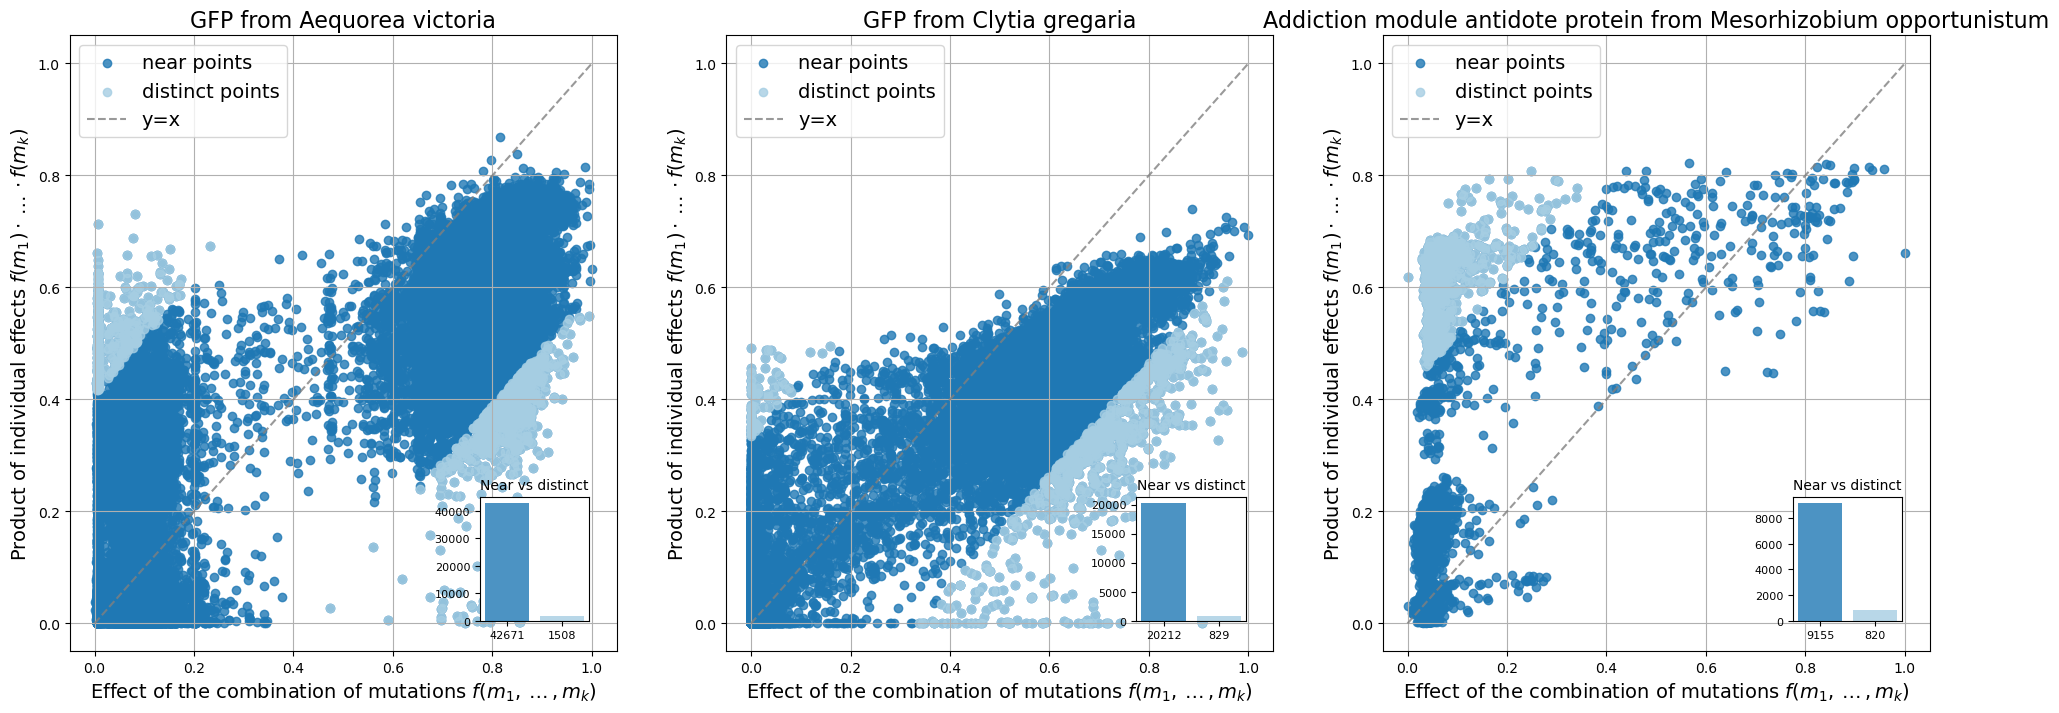

In [5]:
datasets = ["data/ProteinGym_subs_apr_2024/GFP_AEQVI_Sarkisyan_2016.csv",
            "data/ProteinGym_subs_apr_2024/D7PM05_CLYGR_Somermeyer_2022.csv",
            "data/ProteinGym_subs_apr_2024/F7YBW8_MESOW_Aakre_2015.csv"]
titles = ['GFP from Aequorea victoria',
          'GFP from Clytia gregaria',
          'Addiction module antidote protein from Mesorhizobium opportunistum']
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for i, dataset in enumerate(datasets):
    df = pd.read_csv(dataset)
    indices = {}
    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) >= 2:
            indices[tuple(mutations + [ind])] = [-1] * len(mutations)

    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) == 1:
            for key, value in indices.items():
                for j, mut in enumerate(key[:-1]):
                    if mut == mutations[0]:
                        indices[key][j] = ind

    dic_final = {}
    for key, value in indices.items():
        if all(v != -1 for v in value):
            dic_final[key] = value

    scaler = MinMaxScaler()
    df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

    x = []
    y = []
    selected = []
    for key, value in dic_final.items():
        ind = key[-1]
        x.append(df.loc[ind, 'DMS_score_scaled'])
        selected.append(':'.join(key[:-1]))
        product = 1
        for v in value:
            product *= df.loc[v, 'DMS_score_scaled']
        y.append(product)
        
    distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    threshold = mean_distance + 2 * std_distance
    distinct_points = distances > threshold
    distinct_x = np.array(x)[distinct_points.tolist()]
    distinct_y = np.array(y)[distinct_points.tolist()]
    selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]
    cmap = plt.get_cmap('Paired')

    # Bar plot for counts of x and distinct_x
    counts = [len(x), len(distinct_x)]
    bar_labels = [len(x), len(distinct_x)]
    bar_colors = [cmap(1), cmap(0)]
    # Position the bar plot in the right bottom corner
    inset_ax = axes[i].inset_axes([0.75, 0.05, 0.2, 0.2])
    inset_ax.bar(range(len(bar_labels)), counts, color=bar_colors, alpha=0.8)
    inset_ax.set_xticks(range(len(bar_labels)))
    inset_ax.set_xticklabels(bar_labels, fontsize=10)
    inset_ax.set_title('Near vs distinct', fontsize=10)
    inset_ax.tick_params(axis='both', which='major', labelsize=8)

    axes[i].scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
    axes[i].scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
    axes[i].plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
    axes[i].set_xlabel(r'Effect of the combination of mutations $f(m_1, \dots, m_k)$', fontsize=14)
    axes[i].set_ylabel(r'Product of individual effects $f(m_1)\cdot \dots \cdot f(m_k)$', fontsize=14)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].legend(prop={'size': 14})
    axes[i].grid(True)
plt.savefig(f'figures/paper/1d_bar.png', dpi=300)

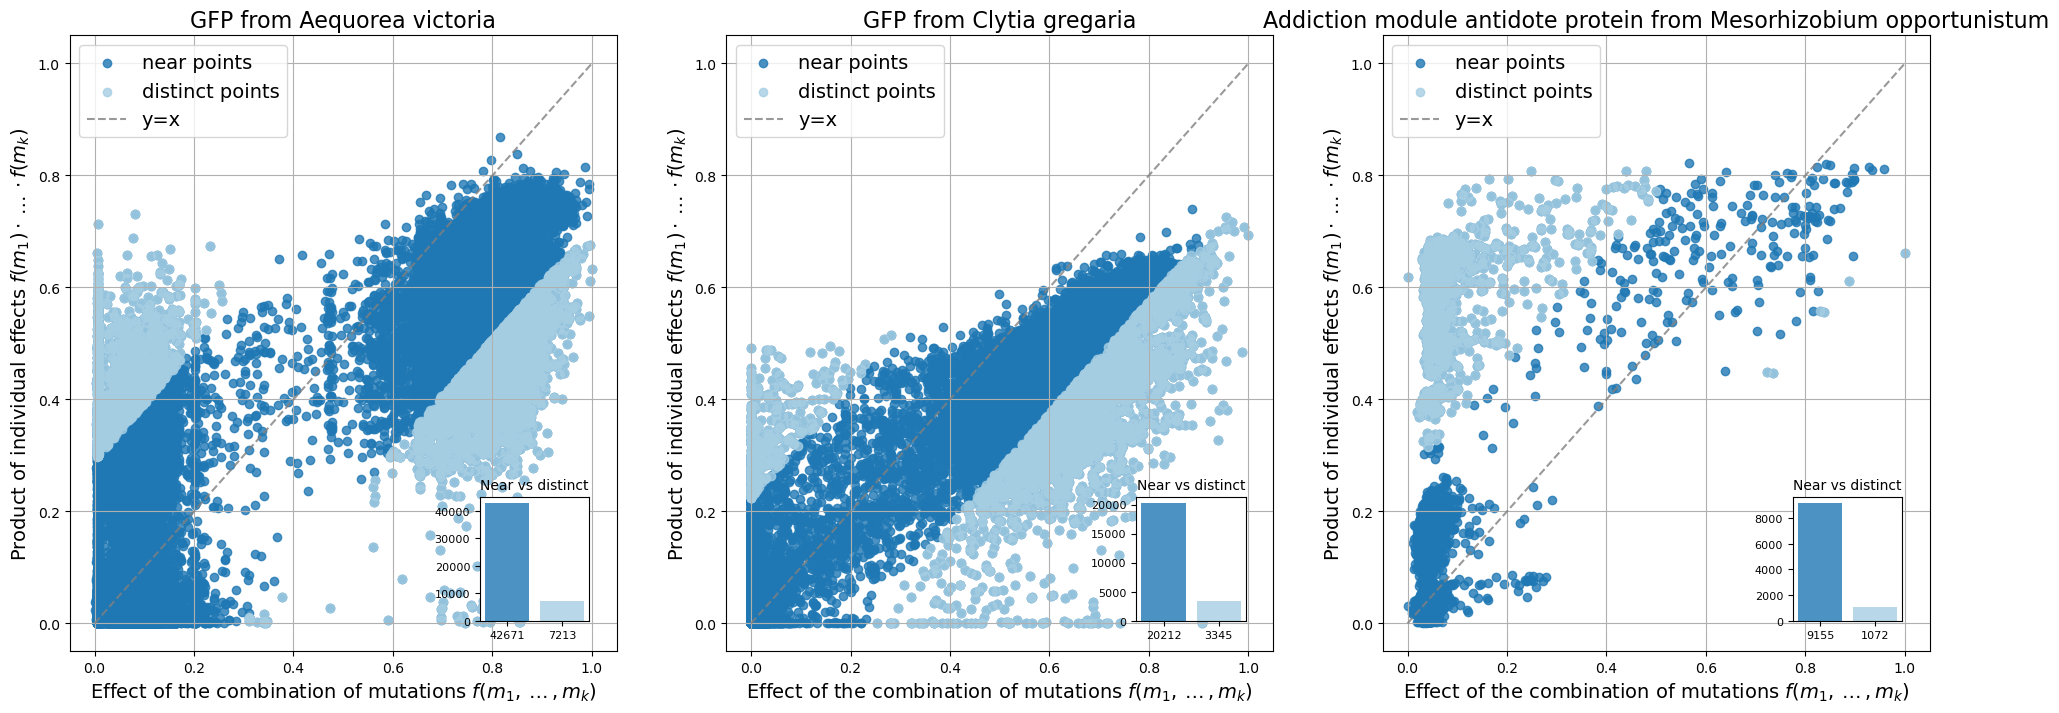

In [6]:
datasets = ["data/ProteinGym_subs_apr_2024/GFP_AEQVI_Sarkisyan_2016.csv",
            "data/ProteinGym_subs_apr_2024/D7PM05_CLYGR_Somermeyer_2022.csv",
            "data/ProteinGym_subs_apr_2024/F7YBW8_MESOW_Aakre_2015.csv"]
titles = ['GFP from Aequorea victoria',
          'GFP from Clytia gregaria',
          'Addiction module antidote protein from Mesorhizobium opportunistum']
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for i, dataset in enumerate(datasets):
    df = pd.read_csv(dataset)
    indices = {}
    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) >= 2:
            indices[tuple(mutations + [ind])] = [-1] * len(mutations)

    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) == 1:
            for key, value in indices.items():
                for j, mut in enumerate(key[:-1]):
                    if mut == mutations[0]:
                        indices[key][j] = ind

    dic_final = {}
    for key, value in indices.items():
        if all(v != -1 for v in value):
            dic_final[key] = value

    scaler = MinMaxScaler()
    df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

    x = []
    y = []
    selected = []
    for key, value in dic_final.items():
        ind = key[-1]
        x.append(df.loc[ind, 'DMS_score_scaled'])
        selected.append(':'.join(key[:-1]))
        product = 1
        for v in value:
            product *= df.loc[v, 'DMS_score_scaled']
        y.append(product)
        
    distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    threshold = mean_distance + 1 * std_distance
    distinct_points = distances > threshold
    distinct_x = np.array(x)[distinct_points.tolist()]
    distinct_y = np.array(y)[distinct_points.tolist()]
    selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]
    cmap = plt.get_cmap('Paired')

    # Bar plot for counts of x and distinct_x
    counts = [len(x), len(distinct_x)]
    bar_labels = [len(x), len(distinct_x)]
    bar_colors = [cmap(1), cmap(0)]
    # Position the bar plot in the right bottom corner
    inset_ax = axes[i].inset_axes([0.75, 0.05, 0.2, 0.2])
    inset_ax.bar(range(len(bar_labels)), counts, color=bar_colors, alpha=0.8)
    inset_ax.set_xticks(range(len(bar_labels)))
    inset_ax.set_xticklabels(bar_labels, fontsize=10)
    inset_ax.set_title('Near vs distinct', fontsize=10)
    inset_ax.tick_params(axis='both', which='major', labelsize=8)

    axes[i].scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
    axes[i].scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
    axes[i].plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
    axes[i].set_xlabel(r'Effect of the combination of mutations $f(m_1, \dots, m_k)$', fontsize=14)
    axes[i].set_ylabel(r'Product of individual effects $f(m_1)\cdot \dots \cdot f(m_k)$', fontsize=14)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].legend(prop={'size': 14})
    axes[i].grid(True)
plt.savefig(f'figures/paper/supp2_bar.png', dpi=300)
# plt.tight_layout()
# plt.show()
#plt.savefig(f'../figures/paper/1c_plot.png', dpi=300)
#plt.savefig(f'../figures/paper/1c_plot.pdf')
#plt.close()

In [ ]:
for dataset in suitable_datasets:
    name = dataset.split('/')[-1].split('.')[0]
    df = pd.read_csv(dataset)
    indices = {}
    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) >= 2:
            indices[tuple(mutations + [ind])] = [-1] * len(mutations)

    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) == 1:
            for key, value in indices.items():
                for j, mut in enumerate(key[:-1]):
                    if mut == mutations[0]:
                        indices[key][j] = ind

    dic_final = {}
    for key, value in indices.items():
        if all(v != -1 for v in value):
            dic_final[key] = value

    scaler = MinMaxScaler()
    df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

    x = []
    y = []
    selected = []
    for key, value in dic_final.items():
        ind = key[-1]
        x.append(df.loc[ind, 'DMS_score_scaled'])
        selected.append(':'.join(key[:-1]))
        product = 1
        for v in value:
            product *= df.loc[v, 'DMS_score_scaled']
        y.append(product)

    # Calculate distances from the line y = x
    distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
    # Calculate mean and standard deviation of the distances
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
    threshold = mean_distance + 1 * std_distance
    # Identify points that are "distinct"
    distinct_points = distances > threshold
    distinct_x = np.array(x)[distinct_points.tolist()]
    distinct_y = np.array(y)[distinct_points.tolist()]
    selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]

    cmap = plt.get_cmap('Paired')
    plt.figure(figsize=[8,8])
    plt.scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
    plt.scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
    plt.plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
    plt.xlabel('Double mutation', fontsize=14)
    plt.ylabel('Multiplication of single mutations', fontsize=14)
    plt.title(f'Measured fluorescence values {name}', fontsize=16)
    plt.legend(prop={'size': 14})
    plt.grid(True)
    plt.savefig(f'figures/plots_datasets/1std/{name}.png')
    plt.close()

In [4]:
for dataset in suitable_datasets:
    name = dataset.split('/')[-1].split('.')[0]
    df = pd.read_csv(dataset)
    indices = {}
    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) >= 2:
            indices[tuple(mutations + [ind])] = [-1] * len(mutations)

    for ind, row in df.iterrows():
        mutations = row['mutant'].split(':')
        if len(mutations) == 1:
            for key, value in indices.items():
                for j, mut in enumerate(key[:-1]):
                    if mut == mutations[0]:
                        indices[key][j] = ind

    dic_final = {}
    for key, value in indices.items():
        if all(v != -1 for v in value):
            dic_final[key] = value

    scaler = MinMaxScaler()
    df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

    x = []
    y = []
    selected = []
    for key, value in dic_final.items():
        ind = key[-1]
        x.append(df.loc[ind, 'DMS_score_scaled'])
        selected.append(':'.join(key[:-1]))
        product = 1
        for v in value:
            product *= df.loc[v, 'DMS_score_scaled']
        y.append(product)

    # Calculate distances from the line y = x
    distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
    # Calculate mean and standard deviation of the distances
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
    threshold = mean_distance + 2 * std_distance
    # Identify points that are "distinct"
    distinct_points = distances > threshold
    distinct_x = np.array(x)[distinct_points.tolist()]
    distinct_y = np.array(y)[distinct_points.tolist()]
    selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]

    cmap = plt.get_cmap('Paired')
    plt.figure(figsize=[8,8])
    plt.scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
    plt.scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
    plt.plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
    plt.xlabel('Double mutation', fontsize=14)
    plt.ylabel('Multiplication of single mutations', fontsize=14)
    plt.title(f'Measured fluorescence values {name}', fontsize=16)
    plt.legend(prop={'size': 14})
    plt.grid(True)
    plt.savefig(f'figures/plots_datasets/2std/{name}.png')
    plt.close()

KeyboardInterrupt: 

In [ ]:
plt.rcParams.update({'font.size': 14})
subsets = []
start = 0
while start != 60:
    subsets.append(suitable_datasets[start:start+12])
    start += 12
subsets.append(suitable_datasets[start:])
for num in range(len(subsets)):
    subset = subsets[num]
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))
    for index in range(len(subset)):
        dataset = subset[index]
        name = dataset.split('/')[-1].split('.')[0]
        df = pd.read_csv(dataset)
        indices = {}
        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) >= 2:
                indices[tuple(mutations + [ind])] = [-1] * len(mutations)

        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) == 1:
                for key, value in indices.items():
                    for j, mut in enumerate(key[:-1]):
                        if mut == mutations[0]:
                            indices[key][j] = ind

        dic_final = {}
        for key, value in indices.items():
            if all(v != -1 for v in value):
                dic_final[key] = value

        scaler = MinMaxScaler()
        df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

        x = []
        y = []
        selected = []
        for key, value in dic_final.items():
            ind = key[-1]
            x.append(df.loc[ind, 'DMS_score_scaled'])
            selected.append(':'.join(key[:-1]))
            product = 1
            for v in value:
                product *= df.loc[v, 'DMS_score_scaled']
            y.append(product)

        # Calculate distances from the line y = x
        distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
        # Calculate mean and standard deviation of the distances
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)
        # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
        threshold = mean_distance + 1 * std_distance
        # Identify points that are "distinct"
        distinct_points = distances > threshold
        distinct_x = np.array(x)[distinct_points.tolist()]
        distinct_y = np.array(y)[distinct_points.tolist()]
        selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]

        i = index // 3
        j = index % 3
        cmap = plt.get_cmap('Paired')
        axes[i, j].scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
        axes[i, j].scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
        axes[i, j].plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
        axes[i, j].set_title(f'{name}')
        axes[i, j].set_xlabel('Double mutation')
        axes[i, j].set_ylabel('Multiplication of single mutations')
        axes[i, j].legend()
        axes[i, j].grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/plots_datasets/1std/all_1std_part{num}.png')

In [ ]:
plt.rcParams.update({'font.size': 14})
subsets = []
start = 0
while start != 60:
    subsets.append(suitable_datasets[start:start+12])
    start += 12
subsets.append(suitable_datasets[start:])
for num in range(len(subsets)):
    subset = subsets[num]
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))
    for index in range(len(subset)):
        dataset = subset[index]
        name = dataset.split('/')[-1].split('.')[0]
        df = pd.read_csv(dataset)
        indices = {}
        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) >= 2:
                indices[tuple(mutations + [ind])] = [-1] * len(mutations)

        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) == 1:
                for key, value in indices.items():
                    for j, mut in enumerate(key[:-1]):
                        if mut == mutations[0]:
                            indices[key][j] = ind

        dic_final = {}
        for key, value in indices.items():
            if all(v != -1 for v in value):
                dic_final[key] = value

        scaler = MinMaxScaler()
        df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

        x = []
        y = []
        selected = []
        for key, value in dic_final.items():
            ind = key[-1]
            x.append(df.loc[ind, 'DMS_score_scaled'])
            selected.append(':'.join(key[:-1]))
            product = 1
            for v in value:
                product *= df.loc[v, 'DMS_score_scaled']
            y.append(product)

        # Calculate distances from the line y = x
        distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
        # Calculate mean and standard deviation of the distances
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)
        # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
        threshold = mean_distance + 2 * std_distance
        # Identify points that are "distinct"
        distinct_points = distances > threshold
        distinct_x = np.array(x)[distinct_points.tolist()]
        distinct_y = np.array(y)[distinct_points.tolist()]
        selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]

        i = index // 3
        j = index % 3
        cmap = plt.get_cmap('Paired')
        axes[i, j].scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
        axes[i, j].scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
        axes[i, j].plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
        axes[i, j].set_title(f'{name}')
        axes[i, j].set_xlabel('Double mutation')
        axes[i, j].set_ylabel('Multiplication of single mutations')
        axes[i, j].legend()
        axes[i, j].grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/plots_datasets/2std/all_2std_part{num}.png')

In [5]:
plt.rcParams.update({'font.size': 14})
subsets = []
start = 0
while start != 60:
    subsets.append(suitable_datasets[start:start+12])
    start += 12
subsets.append(suitable_datasets[start:])
for num in range(len(subsets)):
    subset = subsets[num]
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))
    for index in range(len(subset)):
        dataset = subset[index]
        name = dataset.split('/')[-1].split('.')[0]
        df = pd.read_csv(dataset)
        indices = {}
        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) >= 2:
                indices[tuple(mutations + [ind])] = [-1] * len(mutations)

        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) == 1:
                for key, value in indices.items():
                    for j, mut in enumerate(key[:-1]):
                        if mut == mutations[0]:
                            indices[key][j] = ind

        dic_final = {}
        for key, value in indices.items():
            if all(v != -1 for v in value):
                dic_final[key] = value

        scaler = MinMaxScaler()
        df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

        x = []
        y = []
        selected = []
        for key, value in dic_final.items():
            ind = key[-1]
            x.append(df.loc[ind, 'DMS_score_scaled'])
            selected.append(':'.join(key[:-1]))
            product = 1
            for v in value:
                product *= df.loc[v, 'DMS_score_scaled']
            y.append(product)
            
        # Calculate distances from the line y = x
        distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
        # Calculate mean and standard deviation of the distances
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)
        # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
        threshold = mean_distance + 2 * std_distance
        # Identify points that are "distinct"
        distinct_points = distances > threshold
        distinct_x = np.array(x)[distinct_points.tolist()]
        distinct_y = np.array(y)[distinct_points.tolist()]
        selected_mutations = [element for element, mask in zip(selected, distinct_points.tolist()) if mask]

        i = index // 3
        j = index % 3
        cmap = plt.get_cmap('Paired')


        # Bar plot for counts of x and distinct_x
        counts = [len(x), len(distinct_x)]
        bar_labels = [len(x), len(distinct_x)]
        bar_colors = [cmap(1), cmap(0)]
        # Position the bar plot in the right bottom corner
        inset_ax = axes[i, j].inset_axes([0.75, 0.05, 0.2, 0.2])
        inset_ax.bar(range(len(bar_labels)), counts, color=bar_colors, alpha=0.8)
        inset_ax.set_xticks(range(len(bar_labels)))
        inset_ax.set_xticklabels(bar_labels, fontsize=10)
        inset_ax.set_title('Near vs distinct', fontsize=10)
        inset_ax.tick_params(axis='both', which='major', labelsize=8)

        axes[i, j].scatter(x, y, color=cmap(1), alpha=0.8, label='near points')
        axes[i, j].scatter(distinct_x, distinct_y, color=cmap(0), alpha=0.8, label='distinct points')
        axes[i, j].plot([0, 1], [0, 1], color='grey', alpha=0.8, linestyle='--', label='y=x')
        axes[i, j].set_title(f'{name}')
        axes[i, j].set_xlabel('Double mutation')
        axes[i, j].set_ylabel('Multiplication of single mutations')
        axes[i, j].legend()
        axes[i, j].grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/paper/supp1_part{num}.png', dpi=300)
    plt.close()

# Calculating Spearman correlation for "distant" points (all models, all datasets)

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os

In [5]:
suitable_datasets = []
cols = ['model']
with open('/home/ank24/epistasis_prediction_review/selected_datasets.txt', 'r') as file:
    for line in file:
        dataset = line.strip()
        suitable_datasets.append(dataset)
        cols.append(dataset + '_all')
        cols.append(dataset + '_1std')
        cols.append(dataset + '_2std')
result_all = pd.DataFrame(columns=cols)

### Dotplots

In [ ]:
dfs = {}
selected_mutations = {}
directory = 'data/ProteinGym_subs_apr_2024'

for filename in os.listdir(directory): # iterate over datasets
    file_path = os.path.join(directory, filename)
    dataset = filename.split('.')[0]
    if os.path.isfile(file_path) and dataset in suitable_datasets:
        df = pd.read_csv(file_path)
        indices = {}
        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) >= 2:
                indices[tuple(mutations + [ind])] = [-1] * len(mutations)

        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) == 1:
                for key, value in indices.items():
                    for j, mut in enumerate(key[:-1]):
                        if mut == mutations[0]:
                            indices[key][j] = ind

        dic_final = {}
        for key, value in indices.items():
            if all(v != -1 for v in value):
                dic_final[key] = value

        scaler = MinMaxScaler()
        df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

        x = []
        y = []
        selected = []
        for key, value in dic_final.items():
            ind = key[-1]
            x.append(df.loc[ind, 'DMS_score_scaled'])
            selected.append(':'.join(key[:-1]))
            product = 1
            for v in value:
                product *= df.loc[v, 'DMS_score_scaled']
            y.append(product)

        # Calculate distances from the line y = x
        distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
        # Calculate mean and standard deviation of the distances
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)
        # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
        threshold = mean_distance + 1 * std_distance
        # Identify points that are "distinct"
        distinct_points = distances > threshold
        selected_muts_1 = [element for element, mask in zip(selected, distinct_points.tolist()) if mask] # for 1 std

        threshold = mean_distance + 2 * std_distance
        distinct_points = distances > threshold
        selected_muts_2 = [element for element, mask in zip(selected, distinct_points.tolist()) if mask] # for 2 std
        
        selected_mutations[dataset] = (selected_muts_1, selected_muts_2)
        dfs[dataset] = df# Iterate over all model prediction folders in the directory

In [10]:
def calculate_spearman(result_all, entry_path, model):
    score_columns = []
    score_indices = {}
    for filename in os.listdir(entry_path): # let's just open 1 file and check if there're several rows with predictions (different num of parameters)
        file_path = os.path.join(entry_path, filename)
        dataset = filename.split('.')[0]
        if dataset in suitable_datasets: 
            df = dfs[dataset]
            df_pred = pd.read_csv(file_path)
            for col in df_pred.columns:
                if ('mut' not in col) and ('seq' not in col) and ('DMS_score' not in col):
                    score_columns.append(col)
            break
    for score_column in score_columns:
        new_row = pd.DataFrame(dict(zip(list(result_all.columns), [model + '_' + score_column] + [None]*(result_all.shape[1] - 1))), index=[0])
        result_all = pd.concat([result_all, new_row], ignore_index=True) # SAVE INDICES + SCORE NAMES IN A DICT TO APPEND AFTERWARDS
        score_indices[score_column] = result_all.index[-1]
    for filename in os.listdir(entry_path): # iterate over datasets
        file_path = os.path.join(entry_path, filename)
        dataset = filename.split('.')[0]
        if dataset in suitable_datasets: 
            df = dfs[dataset]
            df_pred = pd.read_csv(file_path)
            if 'mutant' in df_pred.columns:
                if 'DMS_score' in df_pred.columns:
                    merged_df = df.merge(df_pred, left_on=['mutant', 'DMS_score'], right_on=['mutant', 'DMS_score'])
                else:
                    merged_df = df.merge(df_pred, left_on='mutant', right_on='mutant')
            else:
                if 'DMS_score' in df_pred.columns:
                    merged_df = df.merge(df_pred, left_on=['mutated_sequence', 'DMS_score'], right_on=['mutated_sequence', 'DMS_score'])
                else:
                    merged_df = df.merge(df_pred, left_on='mutated_sequence', right_on='mutated_sequence')

            for score_column in score_columns: # calculate for all predicted scores
                if dataset == 'F7YBW7_MESOW_Ding_2023':
                    print('kek')
                spearman_all = spearmanr(merged_df['DMS_score'], merged_df[score_column])[0]

                merged_df['num_mutations'] = merged_df['mutant'].str.split(':').apply(len)
                
                selected_mutations_1, selected_mutations_2 = selected_mutations[dataset]
                merged_df_selected_1 = merged_df[merged_df['mutant'].isin(selected_mutations_1)]
                spearman_distinct_1 = spearmanr(merged_df_selected_1['DMS_score'], merged_df_selected_1[score_column])[0]
                merged_df_selected_2 = merged_df[merged_df['mutant'].isin(selected_mutations_2)]
                spearman_distinct_2 = spearmanr(merged_df_selected_2['DMS_score'], merged_df_selected_2[score_column])[0]

                plt.figure(figsize=[9, 9])
                plt.plot(merged_df['DMS_score'], merged_df[score_column], 'ok', alpha=0.5)
                plt.xlabel('True values', fontsize=15)
                plt.ylabel('Predicted values', fontsize=15)
                plt.title(f'{dataset}. Spearman R = {spearman_all:.2f}', fontsize=15)
                os.makedirs(f'figures/dotplots/all/{dataset}', exist_ok=True)
                plt.savefig(f'figures/dotplots/all/{dataset}/{result_all.loc[result_all.index[-1], 'model']}.png')
                plt.close()

                plt.figure(figsize=[9, 9])
                plt.plot(merged_df_selected_1['DMS_score'], merged_df_selected_1[score_column], 'ok', alpha=0.5)
                plt.xlabel('True values', fontsize=15)
                plt.ylabel('Predicted values', fontsize=15)
                plt.title(f'{dataset}. Spearman R = {spearman_distinct_1:.2f}', fontsize=15)
                os.makedirs(f'figures/dotplots/1std/{dataset}', exist_ok=True)
                plt.savefig(f'figures/dotplots/1std/{dataset}/{result_all.loc[result_all.index[-1], 'model']}.png')
                plt.close()

                plt.figure(figsize=[9, 9])
                plt.plot(merged_df_selected_2['DMS_score'], merged_df_selected_2[score_column], 'ok', alpha=0.5)
                plt.xlabel('True values', fontsize=15)
                plt.ylabel('Predicted values', fontsize=15)
                plt.title(f'{dataset}. Spearman R = {spearman_distinct_2:.2f}', fontsize=15)
                os.makedirs(f'figures/dotplots/2std/{dataset}', exist_ok=True)
                plt.savefig(f'figures/dotplots/2std/{dataset}/{result_all.loc[result_all.index[-1], 'model']}.png')
                plt.close()

                result_all.loc[score_indices[score_column], dataset + '_all'] = f"{spearman_all:.2f}"
                result_all.loc[score_indices[score_column], dataset + '_1std'] = f"{spearman_distinct_1:.2f}"
                result_all.loc[score_indices[score_column], dataset + '_2std'] = f"{spearman_distinct_2:.2f}"
    return result_all

In [ ]:
directory = 'data/zero_shot_substitutions_scores'
for model in os.listdir(directory): # iterate over models
    entry_path = os.path.join(directory, model)
    if any(os.path.isdir(os.path.join(entry_path, entry)) for entry in os.listdir(entry_path)): # case when there are subfolders inside a model (different parameter number)
        for folder_name in os.listdir(entry_path): # iterate over submodels
            folder_path = os.path.join(entry_path, folder_name)
            result_all = calculate_spearman(result_all, folder_path, model + '_' + folder_name)
    else: # standart case
        result_all = calculate_spearman(result_all, entry_path, model)

FileNotFoundError: [Errno 2] No such file or directory: '/wibicomfs/STBS/anastasia/epistasis_prediction_review/figures/dotplots/all/F7YBW7_MESOW_Ding_2023/LinearRegression.png'

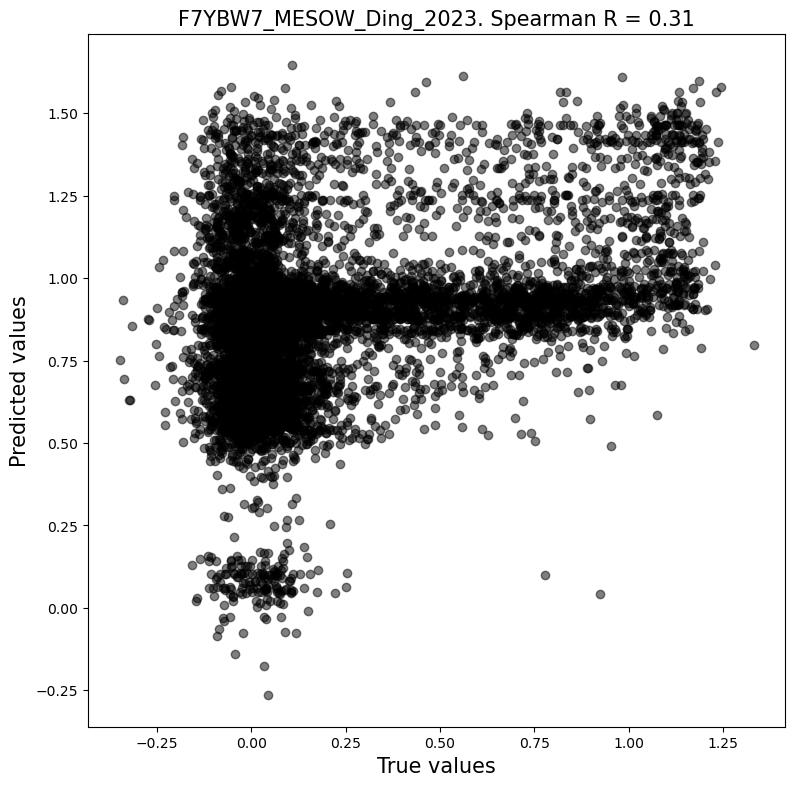

In [ ]:
models = dict(zip(['LinearRegression'], [LinearRegression]))
for dataset in suitable_datasets:
    df = dfs[dataset]
    df['num_mutations'] = df['mutant'].str.split(':').apply(len)
    enc = preprocessing.OneHotEncoder(handle_unknown="ignore")

    max_len = max(len(seq) for seq in df.mutated_sequence)

    sequences = list(df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].mutated_sequence)
    
    sequences = [list(seq) for seq in sequences]
    padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
    padded_array = np.array(padded_sequences)
    enc.fit(padded_array)
    x_train = enc.transform(padded_array).toarray()
    y_train = df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].DMS_score.values.reshape(-1,1)

    selected_mutations_1, selected_mutations_2 = selected_mutations[dataset]

    x_test_1 = y_test_1 = x_test_2 = y_test_2 = None

    sequences = df[df['mutant'].isin(selected_mutations_1)].mutated_sequence
    if len(sequences) != 0:
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test_1 = enc.transform(padded_array).toarray()
        y_test_1 = df[df['mutant'].isin(selected_mutations_1)].DMS_score.values.reshape(-1,1)

    sequences = df[df['mutant'].isin(selected_mutations_2)].mutated_sequence
    if len(sequences) != 0:
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test_2 = enc.transform(padded_array).toarray()
        y_test_2 = df[df['mutant'].isin(selected_mutations_2)].DMS_score.values.reshape(-1,1)

    for model in models:
        model_dataset = models[model]()
        model_dataset.fit(x_train, y_train)

        # sequences = list(df.mutated_sequence)
        sequences = list(df[df['mutant'].apply(lambda x: len(x.split(':')) != 1)].mutated_sequence)
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test = enc.transform(padded_array).toarray()
        y_test = df[df['mutant'].apply(lambda x: len(x.split(':')) != 1)].DMS_score.values.reshape(-1,1)
        y_pred = model_dataset.predict(x_test)
        spearman = spearmanr(y_test, y_pred)[0]

        plt.figure(figsize=[9, 9])
        plt.plot(y_test, y_pred, 'ok', alpha=0.5)
        plt.xlabel('True values', fontsize=15)
        plt.ylabel('Predicted values', fontsize=15)
        plt.title(f'{dataset}. Spearman R = {spearman:.2f}', fontsize=15)
        plt.savefig(f'figures/dotplots/all/{dataset}/LinearRegression.png')
        plt.close()

        if x_test_1 is not None:
            y_pred_1 = model_dataset.predict(x_test_1)
            spearman_distinct_1 = spearmanr(y_test_1, y_pred_1)[0]
            plt.figure(figsize=[9, 9])
            plt.plot(y_test_1, y_pred_1, 'ok', alpha=0.5)
            plt.xlabel('True values', fontsize=15)
            plt.ylabel('Predicted values', fontsize=15)
            plt.title(f'{dataset}. Spearman R = {spearman_distinct_1:.2f}', fontsize=15)
            plt.savefig(f'figures/dotplots/1std/{dataset}/LinearRegression.png')
            plt.close()

        if x_test_2 is not None:
            y_pred_2 = model_dataset.predict(x_test_2)
            spearman_distinct_2 = spearmanr(y_test_2, y_pred_2)[0]
            plt.figure(figsize=[9, 9])
            plt.plot(y_test_2, y_pred_2, 'ok', alpha=0.5)
            plt.xlabel('True values', fontsize=15)
            plt.ylabel('Predicted values', fontsize=15)
            plt.title(f'{dataset}. Spearman R = {spearman_distinct_2:.2f}', fontsize=15)
            plt.savefig(f'figures/dotplots/2std/{dataset}/LinearRegression.png')
            plt.close()

            if dataset == 'D7PM05_CLYGR_Somermeyer_2022':
                table = df[df['mutant'].isin(selected_mutations_2)][['mutant', 'DMS_score']]    
                table['predicted'] = y_pred_2
                x1, y1 = 5000, 10000
                x2, y2 = 30000, 50000
                m = (y2 - y1) / (x2 - x1)
                table['cluster'] = table.apply(lambda row: 'left' if (row['predicted'] - y1) - m * (row['DMS_score'] - x1) > 0 else 'right', axis=1)
                table.to_csv('D7PM05_CLYGR_Somermeyer_2022_linreg_clusters.csv', index=False)

            if dataset == 'GFP_AEQVI_Sarkisyan_2016':
                table = df[df['mutant'].isin(selected_mutations_2)][['mutant', 'DMS_score']]    
                table['predicted'] = y_pred_2
                x1, y1 = 1.5, 1.5
                x2, y2 = 3.5, 4
                m = (y2 - y1) / (x2 - x1)
                table['cluster'] = table.apply(lambda row: 'left' if (row['predicted'] - y1) - m * (row['DMS_score'] - x1) > 0 else 'right', axis=1)
                table.to_csv('GFP_AEQVI_Sarkisyan_2016_linreg_clusters.csv', index=False)

In [ ]:
models = dict(zip(['LinearRegression'], [LinearRegression]))
for dataset in suitable_datasets:
    df = dfs[dataset]
    df['num_mutations'] = df['mutant'].str.split(':').apply(len)
    enc = preprocessing.OneHotEncoder(handle_unknown="ignore")

    max_len = max(len(seq) for seq in df.mutated_sequence)

    sequences = list(df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].mutated_sequence)
    
    sequences = [list(seq) for seq in sequences]
    padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
    padded_array = np.array(padded_sequences)
    enc.fit(padded_array)
    x_train = enc.transform(padded_array).toarray()
    y_train = df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].DMS_score.values.reshape(-1,1)

    selected_mutations_1, selected_mutations_2 = selected_mutations[dataset]

    x_test_1 = y_test_1 = x_test_2 = y_test_2 = None

    sequences = df[df['mutant'].isin(selected_mutations_1)].mutated_sequence
    if len(sequences) != 0:
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test_1 = enc.transform(padded_array).toarray()
        y_test_1 = df[df['mutant'].isin(selected_mutations_1)].DMS_score.values.reshape(-1,1)

    sequences = df[df['mutant'].isin(selected_mutations_2)].mutated_sequence
    if len(sequences) != 0:
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test_2 = enc.transform(padded_array).toarray()
        y_test_2 = df[df['mutant'].isin(selected_mutations_2)].DMS_score.values.reshape(-1,1)

    for model in models:
        model_dataset = models[model]()
        model_dataset.fit(x_train, y_train)

        # sequences = list(df.mutated_sequence)
        sequences = list(df[df['mutant'].apply(lambda x: len(x.split(':')) != 1)].mutated_sequence)
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test = enc.transform(padded_array).toarray()
        y_test = df[df['mutant'].apply(lambda x: len(x.split(':')) != 1)].DMS_score.values.reshape(-1,1)
        y_pred = model_dataset.predict(x_test)
        spearman = spearmanr(y_test, y_pred)[0]

        plt.figure(figsize=[9, 9])
        plt.plot(y_test, y_pred, 'ok', alpha=0.5)
        plt.xlabel('True values', fontsize=15)
        plt.ylabel('Predicted values', fontsize=15)
        plt.title(f'{dataset}. Spearman R = {spearman:.2f}', fontsize=15)
        plt.savefig(f'figures/dotplots/all/{dataset}/LinearRegression.png')
        plt.close()

        if x_test_1 is not None:
            y_pred_1 = model_dataset.predict(x_test_1)
            spearman_distinct_1 = spearmanr(y_test_1, y_pred_1)[0]
            plt.figure(figsize=[9, 9])
            plt.plot(y_test_1, y_pred_1, 'ok', alpha=0.5)
            plt.xlabel('True values', fontsize=15)
            plt.ylabel('Predicted values', fontsize=15)
            plt.title(f'{dataset}. Spearman R = {spearman_distinct_1:.2f}', fontsize=15)
            plt.savefig(f'figures/dotplots/1std/{dataset}/LinearRegression.png')
            plt.close()

        if x_test_2 is not None:
            y_pred_2 = model_dataset.predict(x_test_2)
            spearman_distinct_2 = spearmanr(y_test_2, y_pred_2)[0]
            plt.figure(figsize=[9, 9])
            plt.plot(y_test_2, y_pred_2, 'ok', alpha=0.5)
            plt.xlabel('True values', fontsize=15)
            plt.ylabel('Predicted values', fontsize=15)
            plt.title(f'{dataset}. Spearman R = {spearman_distinct_2:.2f}', fontsize=15)
            plt.savefig(f'figures/dotplots/2std/{dataset}/LinearRegression.png')
            plt.close()

            if dataset == 'D7PM05_CLYGR_Somermeyer_2022':
                table = df[df['mutant'].isin(selected_mutations_2)][['mutant', 'DMS_score']]    
                table['predicted'] = y_pred_2
                x1, y1 = 5000, 10000
                x2, y2 = 30000, 50000
                m = (y2 - y1) / (x2 - x1)
                table['cluster'] = table.apply(lambda row: 'left' if (row['predicted'] - y1) - m * (row['DMS_score'] - x1) > 0 else 'right', axis=1)
                table.to_csv('D7PM05_CLYGR_Somermeyer_2022_linreg_clusters.csv', index=False)

            if dataset == 'GFP_AEQVI_Sarkisyan_2016':
                table = df[df['mutant'].isin(selected_mutations_2)][['mutant', 'DMS_score']]    
                table['predicted'] = y_pred_2
                x1, y1 = 1.5, 1.5
                x2, y2 = 3.5, 4
                m = (y2 - y1) / (x2 - x1)
                table['cluster'] = table.apply(lambda row: 'left' if (row['predicted'] - y1) - m * (row['DMS_score'] - x1) > 0 else 'right', axis=1)
                table.to_csv('GFP_AEQVI_Sarkisyan_2016_linreg_clusters.csv', index=False)

### Constructing spearman tables

In [6]:
dfs = {}
selected_mutations = {}
directory = 'data/ProteinGym_subs_apr_2024'

for filename in os.listdir(directory): # iterate over datasets
    file_path = os.path.join(directory, filename)
    dataset = filename.split('.')[0]
    if os.path.isfile(file_path) and dataset in suitable_datasets:
        df = pd.read_csv(file_path)
        indices = {}
        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) >= 2:
                indices[tuple(mutations + [ind])] = [-1] * len(mutations)

        for ind, row in df.iterrows():
            mutations = row['mutant'].split(':')
            if len(mutations) == 1:
                for key, value in indices.items():
                    for j, mut in enumerate(key[:-1]):
                        if mut == mutations[0]:
                            indices[key][j] = ind

        dic_final = {}
        for key, value in indices.items():
            if all(v != -1 for v in value):
                dic_final[key] = value

        scaler = MinMaxScaler()
        df['DMS_score_scaled'] = scaler.fit_transform(df['DMS_score'].values.reshape(-1, 1))

        x = []
        y = []
        selected = []
        for key, value in dic_final.items():
            ind = key[-1]
            x.append(df.loc[ind, 'DMS_score_scaled'])
            selected.append(':'.join(key[:-1]))
            product = 1
            for v in value:
                product *= df.loc[v, 'DMS_score_scaled']
            y.append(product)
            
        # Calculate distances from the line y = x
        distances = np.abs(np.array(y) - np.array(x)) / np.sqrt(2)
        # Calculate mean and standard deviation of the distances
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)
        # Define a threshold for "distinct" points (e.g., 2 standard deviations from the mean)
        threshold = mean_distance + 1 * std_distance
        # Identify points that are "distinct"
        distinct_points = distances > threshold
        selected_muts_1 = [element for element, mask in zip(selected, distinct_points.tolist()) if mask] # for 1 std

        threshold = mean_distance + 2 * std_distance
        distinct_points = distances > threshold
        selected_muts_2 = [element for element, mask in zip(selected, distinct_points.tolist()) if mask] # for 2 std
        
        selected_mutations[dataset] = (selected_muts_1, selected_muts_2)
        dfs[dataset] = df# Iterate over all model prediction folders in the directory

In [7]:
def calculate_spearman(result_all, entry_path, model):
    score_columns = []
    score_indices = {}
    for filename in os.listdir(entry_path): # let's just open 1 file and check if there're several rows with predictions (different num of parameters)
        file_path = os.path.join(entry_path, filename)
        dataset = filename.split('.')[0]
        if dataset in suitable_datasets: 
            df = dfs[dataset]
            df_pred = pd.read_csv(file_path)
            for col in df_pred.columns:
                if ('mut' not in col) and ('seq' not in col) and ('DMS_score' not in col):
                    score_columns.append(col)
            break
    for score_column in score_columns:
        new_row = pd.DataFrame(dict(zip(list(result_all.columns), [model + '_' + score_column] + [None]*(result_all.shape[1] - 1))), index=[0])
        result_all = pd.concat([result_all, new_row], ignore_index=True) # SAVE INDICES + SCORE NAMES IN A DICT TO APPEND AFTERWARDS
        score_indices[score_column] = result_all.index[-1]
    for filename in os.listdir(entry_path): # iterate over datasets
        file_path = os.path.join(entry_path, filename)
        dataset = filename.split('.')[0]
        if dataset in suitable_datasets: 
            df = dfs[dataset]
            df_pred = pd.read_csv(file_path)
            if 'mutant' in df_pred.columns:
                if 'DMS_score' in df_pred.columns:
                    merged_df = df.merge(df_pred, left_on=['mutant', 'DMS_score'], right_on=['mutant', 'DMS_score'])
                else:
                    merged_df = df.merge(df_pred, left_on='mutant', right_on='mutant')
            else:
                if 'DMS_score' in df_pred.columns:
                    merged_df = df.merge(df_pred, left_on=['mutated_sequence', 'DMS_score'], right_on=['mutated_sequence', 'DMS_score'])
                else:
                    merged_df = df.merge(df_pred, left_on='mutated_sequence', right_on='mutated_sequence')

            for score_column in score_columns: # calculate for all predicted scores
                spearman_all = spearmanr(merged_df[merged_df['mutant'].apply(lambda x: len(x.split(':')) != 1)]['DMS_score'], merged_df[merged_df['mutant'].apply(lambda x: len(x.split(':')) != 1)][score_column])[0]

                merged_df['num_mutations'] = merged_df['mutant'].str.split(':').apply(len)
                
                selected_mutations_1, selected_mutations_2 = selected_mutations[dataset]
                merged_df_selected_1 = merged_df[merged_df['mutant'].isin(selected_mutations_1)]
                spearman_distinct_1 = spearmanr(merged_df_selected_1['DMS_score'], merged_df_selected_1[score_column])[0]
                merged_df_selected_2 = merged_df[merged_df['mutant'].isin(selected_mutations_2)]
                spearman_distinct_2 = spearmanr(merged_df_selected_2['DMS_score'], merged_df_selected_2[score_column])[0]

                result_all.loc[score_indices[score_column], dataset + '_all'] = f"{spearman_all:.2f}"
                result_all.loc[score_indices[score_column], dataset + '_1std'] = f"{spearman_distinct_1:.2f}"
                result_all.loc[score_indices[score_column], dataset + '_2std'] = f"{spearman_distinct_2:.2f}"
    return result_all

In [8]:
directory = 'data/zero_shot_substitutions_scores'
for model in os.listdir(directory): # iterate over models
    entry_path = os.path.join(directory, model)
    if any(os.path.isdir(os.path.join(entry_path, entry)) for entry in os.listdir(entry_path)): # case when there are subfolders inside a model (different parameter number)
        for folder_name in os.listdir(entry_path): # iterate over submodels
            folder_path = os.path.join(entry_path, folder_name)
            result_all = calculate_spearman(result_all, folder_path, model + '_' + folder_name)
    else: # standart case
        result_all = calculate_spearman(result_all, entry_path, model)
result_all.to_csv('all_models.csv')

# Add linreg baseline

In [9]:
result_all = pd.read_csv('all_models.csv', dtype=str)
result_all.drop(columns='Unnamed: 0', inplace=True)

In [10]:
models = dict(zip(['LinearRegression'], [LinearRegression]))
indices = dict(zip(['LinearRegression'], [len(result_all)]))

In [11]:
for dataset in suitable_datasets:
    df = dfs[dataset]
    df['num_mutations'] = df['mutant'].str.split(':').apply(len)
    enc = preprocessing.OneHotEncoder(handle_unknown="ignore")

    max_len = max(len(seq) for seq in df.mutated_sequence)

    sequences = list(df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].mutated_sequence)
    
    sequences = [list(seq) for seq in sequences]
    padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
    padded_array = np.array(padded_sequences)
    enc.fit(padded_array)
    x_train = enc.transform(padded_array).toarray()
    y_train = df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].DMS_score.values.reshape(-1,1)

    selected_mutations_1, selected_mutations_2 = selected_mutations[dataset]

    x_test_1 = y_test_1 = x_test_2 = y_test_2 = None

    sequences = df[df['mutant'].isin(selected_mutations_1)].mutated_sequence
    if len(sequences) != 0:
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test_1 = enc.transform(padded_array).toarray()
        y_test_1 = df[df['mutant'].isin(selected_mutations_1)].DMS_score.values.reshape(-1,1)

    sequences = df[df['mutant'].isin(selected_mutations_2)].mutated_sequence
    if len(sequences) != 0:
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test_2 = enc.transform(padded_array).toarray()
        y_test_2 = df[df['mutant'].isin(selected_mutations_2)].DMS_score.values.reshape(-1,1)

    for model in models:
        result_all.loc[indices[model], 'model'] = model

        model_dataset = models[model]()
        model_dataset.fit(x_train, y_train)

        sequences = list(df[df['mutant'].apply(lambda x: len(x.split(':')) != 1)].mutated_sequence)
        sequences = [list(seq) for seq in sequences]
        padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]
        padded_array = np.array(padded_sequences)
        x_test = enc.transform(padded_array).toarray()
        y_test = df[df['mutant'].apply(lambda x: len(x.split(':')) != 1)].DMS_score.values.reshape(-1,1)
        y_pred = model_dataset.predict(x_test)
        spearman = spearmanr(y_test, y_pred)[0]
        result_all.loc[indices[model], dataset + '_all'] = spearman

        if x_test_1 is not None:
            y_pred_1 = model_dataset.predict(x_test_1)
            spearman_distinct_1 = spearmanr(y_test_1, y_pred_1)[0]
            result_all.loc[indices[model], dataset + '_1std'] = f"{spearman_distinct_1:.2f}"
        else:
            result_all.loc[indices[model], dataset + '_1std'] = 0

        if x_test_2 is not None:
            y_pred_2 = model_dataset.predict(x_test_2)
            spearman_distinct_2 = spearmanr(y_test_2, y_pred_2)[0]
            result_all.loc[indices[model], dataset + '_2std'] = f"{spearman_distinct_2:.2f}"
        else:
            result_all.loc[indices[model], dataset + '_2std'] = 0

In [12]:
result_all.to_csv('all_models.csv')

## Selecting best models

In [13]:
import pandas as pd

file_path = 'all_models.csv'
data = pd.read_csv(file_path)
columns_to_consider = [col for col in data.columns if col.endswith('_all')]
# Add a new column to identify categories (prefixes before '_')
data['category'] = data['model'].str.split('_').str[0]
# Group by category and find the best model in each group based on the highest mean(abs(row)) for '_all' columns
results = data.groupby('category').apply(
    lambda group: group.loc[group[columns_to_consider].abs().mean(axis=1).idxmax()]
)

results.to_csv('best_models.csv', index=False)

/tmp/ipykernel_114708/1718914190.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = data.groupby('category').apply(


# Plots of Spearman values

### Bar plots paper

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os

In [16]:
result_all = pd.read_csv('all_models.csv', dtype=str)
result_all.drop(columns='Unnamed: 0', inplace=True)
result_all.to_csv('all_models.csv', index=False)

result_all = pd.read_csv('best_models.csv', dtype=str)
result_all.drop(columns='Unnamed: 0', inplace=True)
result_all.to_csv('best_models.csv', index=False)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/wibicomfs/STBS/anastasia/epistasis_prediction_review/best_models.csv', index_col=0)
df.index = df.index.to_series().apply(lambda x: x.split('_')[0])
df = df.loc[[i for i in df.index if i != 'LinearRegression'] + ['LinearRegression']]

# Mapping dataset names for titles
dick = {
    'D7PM05_CLYGR_Somermeyer_2022': 'GFP from C. gregaria',
    'F7YBW8_MESOW_Aakre_2015': 'Addition module antidote protein',
    'GFP_AEQVI_Sarkisyan_2016': 'GFP from A. victoria'
}

# Loop through datasets and plot
for dataset in ['D7PM05_CLYGR_Somermeyer_2022',
                'F7YBW8_MESOW_Aakre_2015',
                'GFP_AEQVI_Sarkisyan_2016']:
    all = np.abs(df[dataset + '_all'])
    std1 = np.abs(df[dataset + '_1std'])
    std2 = np.abs(df[dataset + '_2std'])
    cmap = plt.get_cmap('Paired')
    categories = df.index  # Coordinates on the x-axis
    x = np.arange(len(categories))  # Positions for the groups
    width = 0.2  # Width of the bars

    # Adjusted position of the dotted vertical line (to separate Linear Regression)
    linear_reg_index = len(categories) - 1  # Index of Linear Regression
    linear_reg_xpos = x[linear_reg_index] - 2.5 * width  # Adjusted to slightly left

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.bar(x - width, all, width, color='midnightblue', label='All points')
    ax.bar(x, std1, width, color='#fc5a03', label='Distant points (1 std)')
    ax.bar(x + width, std2, width, color='#38a112', label='Distant points (2 std)')

    # Add vertical line to separate Linear Regression
    ax.axvline(linear_reg_xpos, color='red', linestyle='dotted', linewidth=1.5)

    # Add labels, title, and legend
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Spearman correlation', fontsize=14)
    ax.set_title(f'Spearman correlations for {dick[dataset]}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.grid(True, axis='y')
    plt.xticks(rotation=90)
    plt.legend(prop={'size': 14})

    plt.savefig(f'/wibicomfs/STBS/anastasia/epistasis_prediction_review/figures/paper/{dataset}.png', bbox_inches='tight', dpi=300)
    plt.close()

In [18]:
df = pd.read_csv('/wibicomfs/STBS/anastasia/epistasis_prediction_review/all_models.csv', index_col=0)
df = df.loc[[i for i in df.index if i != 'LinearRegression'] + ['LinearRegression']]
dick = {'D7PM05_CLYGR_Somermeyer_2022': 'GFP from C. gregaria',
                'F7YBW8_MESOW_Aakre_2015': 'Addition module antidote protein',
                'GFP_AEQVI_Sarkisyan_2016': 'GFP from A. victoria'}
for dataset in ['D7PM05_CLYGR_Somermeyer_2022',
                'F7YBW8_MESOW_Aakre_2015',
                'GFP_AEQVI_Sarkisyan_2016'] :
    all = np.abs(df[dataset + '_all'])
    std1 = np.abs(df[dataset + '_1std'])
    std2 = np.abs(df[dataset + '_2std'])
    cmap = plt.get_cmap('Paired')
    #plt.figure(figsize=[34,38])
    categories = df.index  # Coordinates on the x-axis
    x = np.arange(len(categories))  # Positions for the groups
    width = 0.2  # Width of the bars

    # Adjusted position of the dotted vertical line (to separate Linear Regression)
    linear_reg_index = len(categories) - 1  # Index of Linear Regression
    linear_reg_xpos = x[linear_reg_index] - 2.5 * width  # Adjusted to slightly left

    fig, ax = plt.subplots(figsize=(28, 8))
    # Plot each set of bars with a specific x offset
    ax.bar(x - width, all, width, color='midnightblue', label='All points')
    ax.bar(x, std1, width, color='#fc5a03', label='Distant points (1 std)')
    ax.bar(x + width, std2, width, color='#38a112', label='Distant points (2 std)')

    # Add vertical line to separate Linear Regression
    ax.axvline(linear_reg_xpos, color='red', linestyle='dotted', linewidth=1.5)

    # Add labels, title, and legend
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Spearman correlation', fontsize=14)
    ax.set_title(f'Spearman correlations for {dick[dataset]}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.grid(True, axis='y')
    plt.xticks(rotation=90)
    plt.legend(prop={'size': 14})
    plt.savefig(f'/wibicomfs/STBS/anastasia/epistasis_prediction_review/figures/paper/{dataset}_supp.png', bbox_inches='tight', dpi=300)
    plt.close()

## All points

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os

In [41]:
suitable_datasets = []
with open('selected_datasets.txt', 'r') as file:
    for line in file:
        dataset = line.strip()
        suitable_datasets.append(dataset)

In [23]:
df = pd.read_csv('../all_Spearman_values.csv', index_col=1)
df.drop(columns='Unnamed: 0', inplace=True)
for dataset in suitable_datasets:
    all = np.abs(df[dataset + '_Spearman_all'])
    std1 = np.abs(df[dataset + '_Spearman_distinct_1std'])
    std2 = np.abs(df[dataset + '_Spearman_distinct_2std'])
    cmap = plt.get_cmap('Paired')
    #plt.figure(figsize=[34,38])
    categories = df.index  # Coordinates on the x-axis
    x = np.arange(len(categories))  # Positions for the groups
    width = 0.2  # Width of the bars
    fig, ax = plt.subplots(figsize=(28, 8))
    # Plot each set of bars with a specific x offset
    ax.bar(x - width, all, width, color='midnightblue', label='All points')
    ax.bar(x, std1, width, color=cmap(1), label='Distant points (1 std)')
    ax.bar(x + width, std2, width, color=cmap(0), label='Distant points (2 std)')
    # Add labels, title, and legend
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Spearman correlation', fontsize=14)
    ax.set_title(f'Spearman correlations for {dataset}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.grid(True, axis='y')
    plt.xticks(rotation=90)
    plt.legend(prop={'size': 14})
    plt.savefig(f'figures/plots_models/{dataset}.svg', bbox_inches='tight')
    plt.close()

## Double/multi

In [27]:
df = pd.read_csv('../all_Spearman_values.csv', index_col=1)
df.drop(columns='Unnamed: 0', inplace=True)
for dataset in suitable_datasets:
    doubles = np.abs(df[dataset + '_Spearman_doubles'])
    multi = np.abs(df[dataset + '_Spearman_multi'])
    std1 = np.abs(df[dataset + '_Spearman_distinct_1std'])
    std2 = np.abs(df[dataset + '_Spearman_distinct_2std'])
    cmap = plt.get_cmap('Paired')
    #plt.figure(figsize=[34,38])
    categories = df.index  # Coordinates on the x-axis
    x = np.arange(len(categories))  # Positions for the groups
    width = 0.2  # Width of the bars
    fig, ax = plt.subplots(figsize=(28, 8))
    # Plot each set of bars with a specific x offset
    ax.bar(x - 1.5*width, doubles, width, color=cmap(6), label='Double mutations')
    ax.bar(x - width/2, multi, width, color=cmap(7), label='Multi (2+) mutations')
    ax.bar(x + width/2, std1, width, color=cmap(1), label='Distant points (1 std)')
    ax.bar(x + 1.5*width, std2, width, color=cmap(0), label='Distant points (2 std)')
    # Add labels, title, and legend
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Spearman correlation', fontsize=14)
    ax.set_title(f'Spearman correlations for {dataset}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.grid(True, axis='y')
    plt.xticks(rotation=90)
    plt.legend(prop={'size': 14})
    plt.savefig(f'../figures/plots_models/{dataset}_multi.svg', bbox_inches='tight')
    plt.close()

# Violin plots

In [42]:
import seaborn as sns

def rename_columns(col, num):
    parts = col.split('_')  # Split by '_'
    return '_'.join(parts[:len(parts) - num])

In [60]:
plots = ['_Spearman_all', '_Spearman_doubles', '_Spearman_multi', '_Spearman_distinct_1std', '_Spearman_distinct_2std']
cnt = 0
for plot in plots:
    df_slice = np.abs(df.filter(like=plot))
    if cnt < 3:
        df_slice.columns = [rename_columns(col, 2) for col in df_slice.columns]
    else:
        df_slice.columns = [rename_columns(col, 3) for col in df_slice.columns]
    cnt += 1
    df_slice.fillna(0, inplace=True)
    plt.figure(figsize=[28,8])
    sns.violinplot(df_slice)
    plt.xlabel('Datasets', fontsize=14)
    plt.ylabel('Spearman correlation', fontsize=14)
    plt.title(f'Spearman correlation of all methods ({plot.split('_')[-1]} points)', fontsize=16)
    plt.xticks(rotation=90)
    plt.grid(True, axis='y')
    plt.savefig(f'../figures/violin_plots/{plot[1:]}.svg', bbox_inches='tight')
    plt.close()

/tmp/ipykernel_114708/1541935416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[selected_columns] = filtered_data[selected_columns].abs()
/tmp/ipykernel_114708/1541935416.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_114708/1541935416.py:40: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


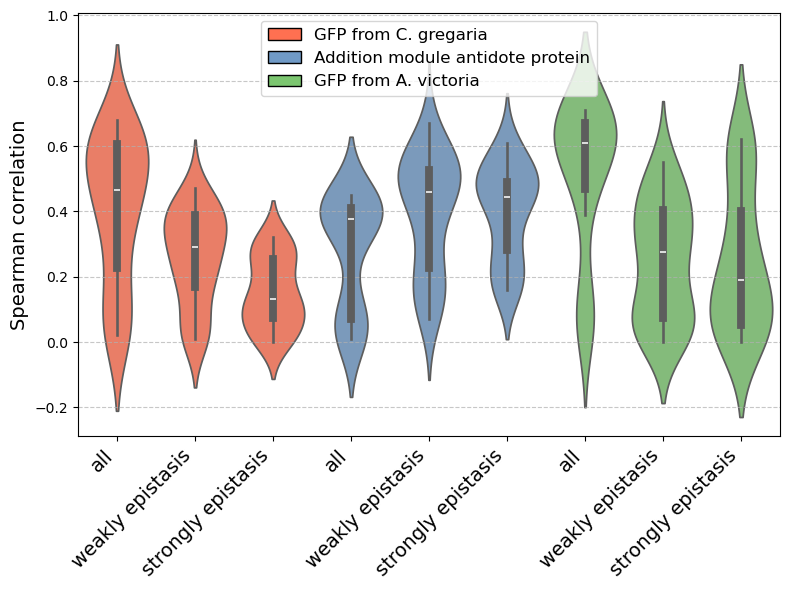

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the data
data = pd.read_csv('best_models.csv')

# List of selected columns (datasets) to include in the plot
selected_columns = [
    "D7PM05_CLYGR_Somermeyer_2022_all", "D7PM05_CLYGR_Somermeyer_2022_1std", "D7PM05_CLYGR_Somermeyer_2022_2std",
    "F7YBW8_MESOW_Aakre_2015_all", "F7YBW8_MESOW_Aakre_2015_1std", "F7YBW8_MESOW_Aakre_2015_2std",
    "GFP_AEQVI_Sarkisyan_2016_all", "GFP_AEQVI_Sarkisyan_2016_1std", "GFP_AEQVI_Sarkisyan_2016_2std"
]

# Add the 'model' column to the selected columns for context
columns_to_plot = ["model"] + selected_columns

# Filter the DataFrame
filtered_data = data[columns_to_plot]
# Take the absolute value of all numerical columns
filtered_data[selected_columns] = filtered_data[selected_columns].abs()
# Remove rows which have 'LinearRegression' in the 'model' column
filtered_data = filtered_data[~filtered_data['model'].str.contains('LinearRegression')]
# Melt the filtered DataFrame into long format for plotting
df_melted = filtered_data.melt(id_vars=["model"], var_name="Dataset", value_name="Spearman correlation")
df_melted.to_csv('tabel.csv')

# Set up the plot
plt.figure(figsize=(8, 6))

# Define a custom color palette
palette = [
    "#ff7051", "#ff7051", "#ff7051",  # Colors for D7PM05_CLYGR (orange shades)
    "#709ac6", "#709ac6", "#709ac6",  # Colors for F7YBW8_MESOW (blue shades)
    "#7cc670", "#7cc670", "#7cc670"   # Colors for GFP_AEQVI (green shades)
]

# Create the violin plot
sns.violinplot(
    data=df_melted,
    x="Dataset",
    y="Spearman correlation",
    palette=palette,
    scale="width",
    inner="box"
)

# Customize the plot
plt.ylabel("Spearman correlation", fontsize=14)

# Custom x-tick labels
custom_labels = [
    "all", "weakly epistasis", "strongly epistasis",
    "all", "weakly epistasis", "strongly epistasis",
    "all", "weakly epistasis", "strongly epistasis"
]
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=45, fontsize=14, ha='right')

# Remove x-axis label
plt.xlabel(None)

# Add a legend for the colors
legend_elements = [
    Patch(facecolor="#ff7051", edgecolor='k', label="GFP from C. gregaria"),
    Patch(facecolor="#709ac6", edgecolor='k', label="Addition module antidote protein"),
    Patch(facecolor="#7cc670", edgecolor='k', label="GFP from A. victoria")
]
plt.legend(handles=legend_elements, loc="upper center", fontsize=12, title_fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('figures/paper/2.png', dpi=300)
plt.show()


In [21]:
import pandas as pd

# Load the dataset
data = pd.read_csv('tabel.csv')  # Replace with your actual file name

# Calculate summary statistics
statistics_summary = data.groupby('Dataset')['Spearman correlation'].agg(
    median='median',
    min='min',
    max='max',
    mean='mean',
    std='std'
).reset_index()

# Reorder the rows to match the order in the violin plot
selected_columns_order = [
    "D7PM05_CLYGR_Somermeyer_2022_all", "D7PM05_CLYGR_Somermeyer_2022_1std", "D7PM05_CLYGR_Somermeyer_2022_2std",
    "F7YBW8_MESOW_Aakre_2015_all", "F7YBW8_MESOW_Aakre_2015_1std", "F7YBW8_MESOW_Aakre_2015_2std",
    "GFP_AEQVI_Sarkisyan_2016_all", "GFP_AEQVI_Sarkisyan_2016_1std", "GFP_AEQVI_Sarkisyan_2016_2std"
]

# Reorder the DataFrame to match the selected_columns order
statistics_summary = statistics_summary.set_index('Dataset')
statistics_summary = statistics_summary.loc[selected_columns_order].reset_index()

statistics_summary.to_csv('table1.csv', index=False)

/tmp/ipykernel_114708/1698327467.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[selected_columns] = filtered_data[selected_columns].abs()
/tmp/ipykernel_114708/1698327467.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_114708/1698327467.py:39: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


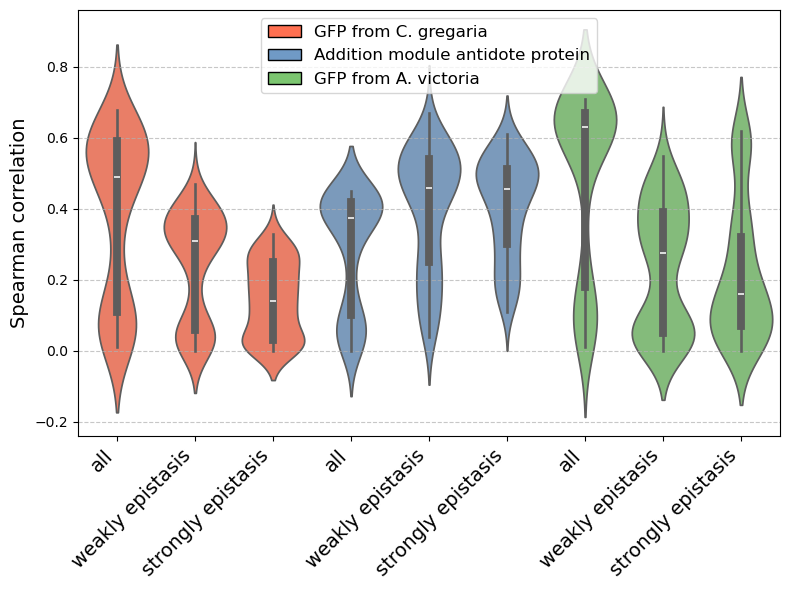

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the data
data = pd.read_csv('all_models.csv')

# List of selected columns (datasets) to include in the plot
selected_columns = [
    "D7PM05_CLYGR_Somermeyer_2022_all", "D7PM05_CLYGR_Somermeyer_2022_1std", "D7PM05_CLYGR_Somermeyer_2022_2std",
    "F7YBW8_MESOW_Aakre_2015_all", "F7YBW8_MESOW_Aakre_2015_1std", "F7YBW8_MESOW_Aakre_2015_2std",
    "GFP_AEQVI_Sarkisyan_2016_all", "GFP_AEQVI_Sarkisyan_2016_1std", "GFP_AEQVI_Sarkisyan_2016_2std"
]

# Add the 'model' column to the selected columns for context
columns_to_plot = ["model"] + selected_columns

# Filter the DataFrame
filtered_data = data[columns_to_plot]
# Take the absolute value of all numerical columns
filtered_data[selected_columns] = filtered_data[selected_columns].abs()
# Remove rows which have 'LinearRegression' in the 'model' column
filtered_data = filtered_data[~filtered_data['model'].str.contains('LinearRegression')]
# Melt the filtered DataFrame into long format for plotting
df_melted = filtered_data.melt(id_vars=["model"], var_name="Dataset", value_name="Spearman correlation")

# Set up the plot
plt.figure(figsize=(8, 6))

# Define a custom color palette
palette = [
    "#ff7051", "#ff7051", "#ff7051",  # Colors for D7PM05_CLYGR (orange shades)
    "#709ac6", "#709ac6", "#709ac6",  # Colors for F7YBW8_MESOW (blue shades)
    "#7cc670", "#7cc670", "#7cc670"   # Colors for GFP_AEQVI (green shades)
]

# Create the violin plot
sns.violinplot(
    data=df_melted,
    x="Dataset",
    y="Spearman correlation",
    palette=palette,
    scale="width",
    inner="box"
)

# Customize the plot
plt.ylabel("Spearman correlation", fontsize=14)

# Custom x-tick labels
custom_labels = [
    "all", "weakly epistasis", "strongly epistasis",
    "all", "weakly epistasis", "strongly epistasis",
    "all", "weakly epistasis", "strongly epistasis"
]
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=45, fontsize=14, ha='right')

# Remove x-axis label
plt.xlabel(None)

# Add a legend for the colors
legend_elements = [
    Patch(facecolor="#ff7051", edgecolor='k', label="GFP from C. gregaria"),
    Patch(facecolor="#709ac6", edgecolor='k', label="Addition module antidote protein"),
    Patch(facecolor="#7cc670", edgecolor='k', label="GFP from A. victoria")
]
plt.legend(handles=legend_elements, loc="upper center", fontsize=12, title_fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('figures/paper/supp3.png', dpi=300)
plt.show()

# (Almost) constant linreg

Coding: seq[i] = 1 if there's a mutation on pos i

In [227]:
suitable_datasets = []
cols = ['model']
with open('/home/ank24/epistasis_prediction_review/selected_datasets.txt', 'r') as file:
    for line in file:
        dataset = line.strip()
        suitable_datasets.append(dataset)
        cols.append(dataset + '_Spearman_all')
        cols.append(dataset + '_Spearman_doubles')
        cols.append(dataset + '_Spearman_multi')
        cols.append(dataset + '_Spearman_distinct_1std')
        cols.append(dataset + '_Spearman_distinct_2std')
result_all = pd.DataFrame(columns=cols)

In [231]:
models = dict(zip(['LinearRegression', 'Ridge'], [LinearRegression, Ridge]))
indices = dict(zip(['LinearRegression', 'Ridge'], [0, 1]))

for dataset in suitable_datasets:
    df = dfs[dataset]
    df['mutations'] = df['mutant'].str.split(':')
    x_train = []
    maxlen = 0
    for seq in df["mutated_sequence"]:
        if len(seq) > maxlen:
            maxlen = len(seq)
    for index, row in df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].iterrows(): # only single mutations
        base = [0]*max_len
        for pos in row['mutations']:
            base[int(pos[1:len(pos)-1]) - 1] = 1
        x_train.append(base)

    y_train = df[df['mutant'].apply(lambda x: len(x.split(':')) == 1)].DMS_score.values.reshape(-1,1)

    selected_mutations_1, selected_mutations_2 = selected_mutations[dataset]

    x_test_doubles = y_test_doubles = x_test_multi = y_test_multi = x_test_1 = y_test_1 = x_test_2 = y_test_2 = None

    sequences = df[df['num_mutations'] == 2].mutated_sequence
    if len(sequences) != 0:
        x_test_doubles = []
        for index, row in df[df['num_mutations'] == 2].iterrows():
            base = [0]*max_len
            for pos in row['mutations']:
                base[int(pos[1:len(pos)-1]) - 1] = 1
            x_test_doubles.append(base)
        y_test_doubles = df[df['num_mutations'] == 2].DMS_score.values.reshape(-1,1)

    sequences = df[df['num_mutations'] >= 2].mutated_sequence
    if len(sequences) != 0:
        x_test_multi = []
        for index, row in df[df['num_mutations'] >= 2].iterrows():
            base = [0]*max_len
            for pos in row['mutations']:
                base[int(pos[1:len(pos)-1]) - 1] = 1
            x_test_multi.append(base)
        y_test_multi = df[df['num_mutations'] >= 2].DMS_score.values.reshape(-1,1)

    sequences = df[df['mutant'].isin(selected_mutations_1)].mutated_sequence
    if len(sequences) != 0:
        x_test_1 = []
        for index, row in df[df['mutant'].isin(selected_mutations_1)].iterrows():
            base = [0]*max_len
            for pos in row['mutations']:
                base[int(pos[1:len(pos)-1]) - 1] = 1
            x_test_1.append(base)
        y_test_1 = df[df['mutant'].isin(selected_mutations_1)].DMS_score.values.reshape(-1,1)

    sequences = df[df['mutant'].isin(selected_mutations_2)].mutated_sequence
    if len(sequences) != 0:
        x_test_2 = []
        for index, row in df[df['mutant'].isin(selected_mutations_2)].iterrows():
            base = [0]*max_len
            for pos in row['mutations']:
                base[int(pos[1:len(pos)-1]) - 1] = 1
            x_test_2.append(base)
        y_test_2 = df[df['mutant'].isin(selected_mutations_2)].DMS_score.values.reshape(-1,1)

    for model in models:
        result_all.loc[indices[model], 'model'] = model

        model_dataset = models[model]()
        model_dataset.fit(x_train, y_train)

        x_test = []
        for index, row in df.iterrows():
            base = [0]*max_len
            for pos in row['mutations']:
                base[int(pos[1:len(pos)-1]) - 1] = 1
            x_test.append(base)

        y_test = df.DMS_score.values.reshape(-1,1)
        y_pred = model_dataset.predict(x_test)
        spearman = spearmanr(y_test, y_pred)[0]
        result_all.loc[indices[model], dataset + '_Spearman_all'] = spearman

        if x_test_doubles is not None:
            y_pred_doubles = model_dataset.predict(x_test_doubles)
            spearman_doubles = spearmanr(y_test_doubles, y_pred_doubles)[0]
            result_all.loc[indices[model], dataset + '_Spearman_doubles'] = f"{spearman_doubles:.2f}"
        else:
            result_all.loc[indices[model], dataset + '_Spearman_doubles'] = 0

        if x_test_multi is not None:
            y_pred = model_dataset.predict(x_test_multi)
            spearman = spearmanr(y_test_multi, y_pred)[0]
            result_all.loc[indices[model], dataset + '_Spearman_multi'] = f"{spearman:.2f}"
        else:
            result_all.loc[indices[model], dataset + '_Spearman_multi'] = 0

        if x_test_1 is not None:
            y_pred_1 = model_dataset.predict(x_test_1)
            spearman_distinct_1 = spearmanr(y_test_1, y_pred_1)[0]
            result_all.loc[indices[model], dataset + '_Spearman_distinct_1std'] = f"{spearman_distinct_1:.2f}"
        else:
            result_all.loc[indices[model], dataset + '_Spearman_distinct_1std'] = 0

        if x_test_2 is not None:
            y_pred_2 = model_dataset.predict(x_test_2)
            spearman_distinct_2 = spearmanr(y_test_2, y_pred_2)[0]
            result_all.loc[indices[model], dataset + '_Spearman_distinct_2std'] = f"{spearman_distinct_2:.2f}"
        else:
            result_all.loc[indices[model], dataset + '_Spearman_distinct_2std'] = 0

In [232]:
result_all

In [233]:
result_all.to_csv('../constant_linreg.csv')

In [239]:
df = pd.read_csv('../constant_linreg.csv', index_col=1)
df.drop(columns='Unnamed: 0', inplace=True)
for dataset in suitable_datasets:
    all = np.abs(df[dataset + '_Spearman_all'])
    doubles = np.abs(df[dataset + '_Spearman_doubles'])
    multi = np.abs(df[dataset + '_Spearman_multi'])
    std1 = np.abs(df[dataset + '_Spearman_distinct_1std'])
    std2 = np.abs(df[dataset + '_Spearman_distinct_2std'])
    cmap = plt.get_cmap('Paired')
    #plt.figure(figsize=[34,38])
    categories = df.index  # Coordinates on the x-axis
    x = np.arange(len(categories))  # Positions for the groups
    width = 0.1  # Width of the bars
    fig, ax = plt.subplots(figsize=(18, 8))
    # Plot each set of bars with a specific x offset
    ax.bar(x - 2*width, all, width, color=cmap(4), label='All points')
    ax.bar(x - width, doubles, width, color=cmap(6), label='Double mutations')
    ax.bar(x, multi, width, color=cmap(7), label='Multi (2+) mutations')
    ax.bar(x + width, std1, width, color=cmap(1), label='Distant points (1 std)')
    ax.bar(x + 2*width, std2, width, color=cmap(0), label='Distant points (2 std)')
    # Add labels, title, and legend
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Spearman correlation', fontsize=14)
    ax.set_title(f'Spearman correlations for {dataset}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.grid(True, axis='y')
    plt.legend(prop={'size': 14})
    plt.savefig(f'../figures/plots_linreg/{dataset}.svg', bbox_inches='tight')
    plt.close()

In [241]:
df = dfs["D7PM05_CLYGR_Somermeyer_2022"]
df['mutations'] = df['mutant'].str.split(':')

In [244]:
df

In [250]:
df[df['mutant'].apply(lambda x: len(x.split(':')) == 2)]['DMS_score_scaled']

In [265]:
plt.figure(figsize=[9,6])
plt.hist(df[df['mutant'].apply(lambda x: len(x.split(':')) == 4)]['DMS_score_scaled'], bins=100, color='green')
plt.grid(True)
plt.xlabel("Scaled fluorescence value")
plt.ylabel("Number of sequences")
plt.title("GFP Clytia 4 mutations")
plt.savefig(f'../figures/GFP_Sommermeyer_4.png', bbox_inches='tight')
plt.close()